https://azad-wolf.medium.com/latent-space-representation-a-hands-on-tutorial-on-autoencoders-in-tensorflow-57735a1c0f3f

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.0 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [14]:
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib


## create train and validation datasets
DB_PATH = "//kaggle/input/fashion-product-images-small/images/"
BUFFER_SIZE = 10000
BATCH_SIZE = 1000
IMG_WIDTH = 60
IMG_HEIGHT = 60


In [13]:
!pwd

!ls -U //kaggle/input/fashion-product-images-small/images | head -4


/kaggle/working
31973.jpg
30778.jpg
19812.jpg
22735.jpg
ls: write error: Broken pipe


In [15]:

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)

    input_image = tf.cast(image, tf.float32)
    return input_image

def random_crop(input_image):
    cropped_image = tf.image.random_crop(
      input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

def resize(input_image):
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

def normalize(input_image):
    input_image = (input_image / 255)
    return input_image

@tf.function()
def random_jitter(input_image):
    input_image = random_crop(input_image)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        
    return input_image

def load_image_train(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image

def load_image_test(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)
    return input_image,input_image


data_dir = pathlib.Path(DB_PATH)
image_count = len(list(data_dir.glob('*.jpg')))
print(f"image count {image_count}")
dataset = tf.data.Dataset.list_files(DB_PATH)


val_size = int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


train_ds = train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_ds = val_ds.map(load_image_test)
val_ds = val_ds.batch(BATCH_SIZE)



image count 44441
0
1


In [16]:
file_pattern = DB_PATH + "*.jpg"
print(file_pattern)
dataset = tf.data.Dataset.list_files(file_pattern)

val_size = int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

//kaggle/input/fashion-product-images-small/images/*.jpg


In [6]:
tf.data.Dataset.list_files(DB_PATH+"*.jpg")

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [25]:
tds=val_ds.take(1)

In [26]:
??tds

Type:           _TakeDataset
String form:    <_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Length:         1
File:           /opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/take_op.py
Source:        
class _TakeDataset(dataset_ops.UnaryUnchangedStructureDataset):
  """A `Dataset` containing the first `count` elements from its input."""

  def __init__(self, input_dataset, count, name=None):
    """See `Dataset.take()` for details."""
    self._input_dataset = input_dataset
    self._count = ops.convert_to_tensor(count, dtype=dtypes.int64, name="count")
    self._name = name
    variant_tensor = gen_dataset_ops.take_dataset(
        input_dataset._variant_tensor,  # pylint: disable=protected-access
        count=self._count,
        **self._common_args)
    super().__init__(input_dataset, variant_tensor)
Init docstring: See `Dataset.take()` for details.

The example I am following expects two results from take, but there is only 1 (a dataset).  However, it is not obvious how I extract the actual data from the dataset.  This example shows how to step through the dataset. But I only have one item, so it is clunky to have to specify a loop to get the one piece of info I need!

In [30]:
for elem in tds:
  print(elem.numpy())

b'//kaggle/input/fashion-product-images-small/images/16272.jpg'


Still a bit clunky, but this might work...

In [39]:
elem = next(iter(tds))
print(elem.numpy())

b'//kaggle/input/fashion-product-images-small/images/14540.jpg'


In [36]:
images = (val_ds.take(1).as_numpy_iterator())[0]
print(images)

TypeError: 'NumpyIterator' object is not subscriptable

In [19]:
list(val_ds.as_numpy_iterator())[0]

b'//kaggle/input/fashion-product-images-small/images/39016.jpg'

In [ ]:
plt.figure(figsize=(15, 5))
for tds in val_ds.take(1):
    for i in range(45):
      ax = plt.subplot(3, 15, i + 1)
      elem = next(iter(tds))
      plt.imshow(elem.numpy().astype("float32"))
      plt.axis("off")

TypeError: Image data of dtype |S60 cannot be converted to float

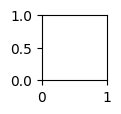

In [44]:
plt.figure(figsize=(15, 5))
samples = 1
tds  = val_ds.take(samples)
for i in range(samples):
    ax = plt.subplot(3, 15, i + 1)
    elem = next(iter(tds))
    plt.imshow(elem.numpy())
    plt.axis("off")